# Robot Dynamics Model Training
This notebook trains a robot dynamics model using the architecture specified. The model will predict the next state of the robot given a sequence of previous states and actions.

In [4]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Ensure matplotlib inline mode for Jupyter
%matplotlib inline

### Load the Dataset

In [6]:
# Load the dataset
file_path = 'load_data.csv'  # replace with the actual path to your dataset
data = pd.read_csv(file_path)

# Display the first few rows
data.head()

,timestamp,x,y,z,yaw,accel,steer
0,2377.313008,452203.077897,3.949655e+06,90.565314,-2.059803,0.0,-18.0
1,2377.412817,452203.077510,3.949655e+06,90.573598,-2.062122,0.0,-17.0
2,2377.512950,452203.072350,3.949655e+06,90.562182,-2.063811,0.0,-18.0
3,2377.612945,452203.072903,3.949655e+06,90.563098,-2.063259,0.0,-16.0
4,2377.728985,452203.068572,3.949655e+06,90.557390,-2.063614,0.0,-16.0


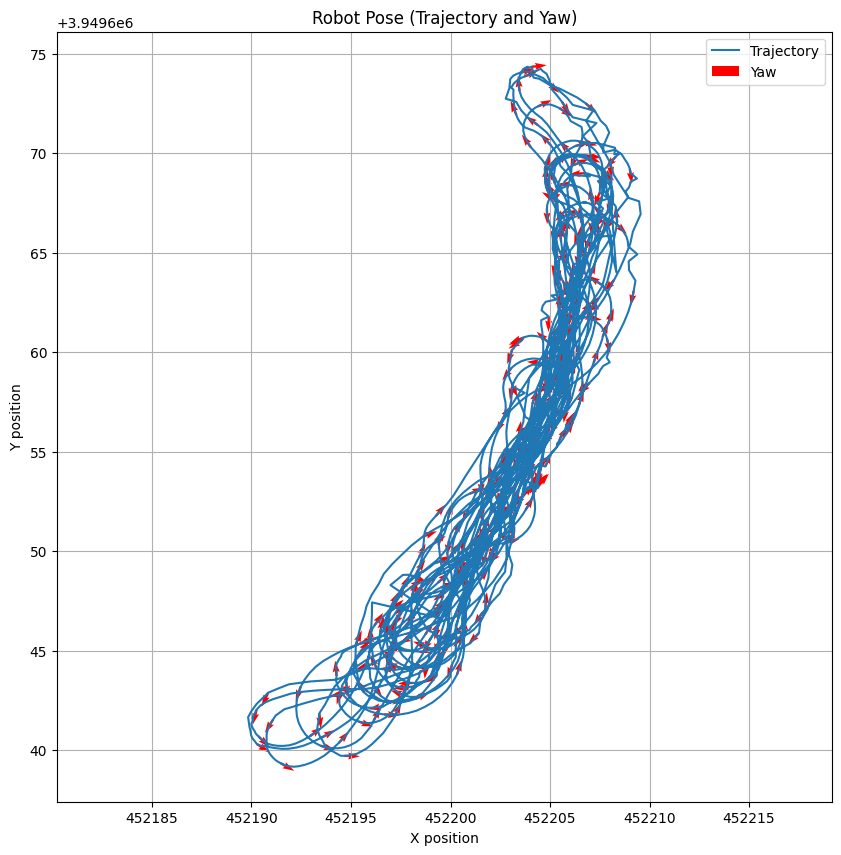

In [7]:
# Extract the pose data (x, y, and yaw)
x = data['x']
y = data['y']
yaw = data['yaw']

# Create a figure for the plot
plt.figure(figsize=(10, 10))

# Plot the robot's trajectory
plt.plot(x, y, label="Trajectory")

# Add quiver plot to show yaw at different points
skip = 10  # Plot yaw every 'skip' points to avoid clutter
plt.quiver(x[::skip], y[::skip], np.cos(yaw[::skip]), np.sin(yaw[::skip]), 
           color='r', scale=50, label="Yaw")

# Add labels and title
plt.xlabel("X position")
plt.ylabel("Y position")
plt.title("Robot Pose (Trajectory and Yaw)")
plt.legend()

# Show the plot
plt.grid(True)
plt.axis('equal')  # Ensure equal scaling for both axes
plt.show()

### Data Preprocessing
We will create input sequences of length `h` for both the state and action variables, and output sequences for the corresponding next state.

In [10]:
# Extract state and action data
state_columns = ['x', 'y', 'yaw']
action_columns = ['accel', 'steer']

states = data[state_columns].values
actions = data[action_columns].values

# Create sequences with history length h
h = 10  # history length
input_sequences = []
output_sequences = []

for i in range(len(states) - h):
    input_seq = np.concatenate((states[i:i+h], actions[i:i+h]), axis=1).flatten()
    output_seq = states[i+h]  # the next state to predict
    input_sequences.append(input_seq)
    output_sequences.append(output_seq)

input_sequences = np.array(input_sequences)
output_sequences = np.array(output_sequences)

# Convert to PyTorch tensors
inputs = torch.tensor(input_sequences, dtype=torch.float32)
outputs = torch.tensor(output_sequences, dtype=torch.float32)

inputs.shape, outputs.shape  # Check the shapes


(torch.Size([4026, 50]), torch.Size([4026, 3]))

### Define the Model
The model architecture is as follows:

In [11]:
# Define the model
class RobotDynamicsModel(nn.Module):
    def __init__(self, input_size):
        super(RobotDynamicsModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 2 * input_size)
        self.fc2 = nn.Linear(2 * input_size, 4 * input_size)
        self.fc3 = nn.Linear(4 * input_size, 6 * input_size)
        self.fc4 = nn.Linear(6 * input_size, 2 * input_size)
        self.output_layer = nn.Linear(2 * input_size, len(state_columns))  # Output size is |x| = 3

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.output_layer(x)
        return x

# Instantiate the model
input_size = h * (len(state_columns) + len(action_columns))  # h * (|x| + |a|)
model = RobotDynamicsModel(input_size)
model

RobotDynamicsModel(
  (fc1): Linear(in_features=50, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=300, bias=True)
  (fc4): Linear(in_features=300, out_features=100, bias=True)
  (output_layer): Linear(in_features=100, out_features=3, bias=True)
)

### Training the Model
We'll now train the model using the Mean Squared Error (MSE) loss function and the Adam optimizer.

In [12]:
# Check for CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the GPU
model = RobotDynamicsModel(input_size).to(device)

# Move the data to the GPU
inputs = inputs.to(device)
outputs = outputs.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Training settings
epochs = 100000
loss_threshold = 10  # Define your loss threshold
min_loss = float('inf')
losses = []  # To store the loss values
filtered_losses = []  # To store non-outlier loss values for plotting



In [13]:
# Train the model
for epoch in range(epochs):
    optimizer.zero_grad()

    predictions = model(inputs)  # Predictions are now on GPU
    loss = criterion(predictions, outputs)  # Loss is computed on GPU
    loss.backward()  # Backpropagation on GPU
    optimizer.step()

    current_loss = loss.item()
    losses.append(current_loss)
    
    # Outlier detection: filter out any loss value above a certain threshold
    if current_loss <= loss_threshold:
        filtered_losses.append(current_loss)

    else:
        # print(predictions.shape, outputs.shape)
        pass

    # Save the model if loss is below the threshold and is the minimum observed
    if current_loss < loss_threshold and current_loss < min_loss:
        min_loss = current_loss
        torch.save(model.state_dict(), 'best_model_below_threshold.pth')
        print(f'Model saved at epoch {epoch + 1} with loss: {current_loss:.4f}')
    
    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {current_loss:.4f}')

Epoch [1000/100000], Loss: 1314.9265
Epoch [2000/100000], Loss: 877.7751
Epoch [3000/100000], Loss: 556.0894
Epoch [4000/100000], Loss: 414.7854
Epoch [5000/100000], Loss: 361.0428
Epoch [6000/100000], Loss: 327.3129
Epoch [7000/100000], Loss: 296.7844
Epoch [8000/100000], Loss: 261.7254
Epoch [9000/100000], Loss: 217.6951
Epoch [10000/100000], Loss: 164.8435
Epoch [11000/100000], Loss: 107.3413
Epoch [12000/100000], Loss: 57.5616
Epoch [13000/100000], Loss: 46.9742
Epoch [14000/100000], Loss: 44.8164
Epoch [15000/100000], Loss: 41.5900
Epoch [16000/100000], Loss: 37.1115
Epoch [17000/100000], Loss: 33.0675
Epoch [18000/100000], Loss: 30.2459
Epoch [19000/100000], Loss: 26.4676
Epoch [20000/100000], Loss: 21.8689
Epoch [21000/100000], Loss: 308661152.0000
Epoch [22000/100000], Loss: 17.0034
Epoch [23000/100000], Loss: 16.6197
Epoch [24000/100000], Loss: 15.9828
Epoch [25000/100000], Loss: 15.0878
Epoch [26000/100000], Loss: 13.8462
Epoch [27000/100000], Loss: 12.3654
Epoch [28000/10000

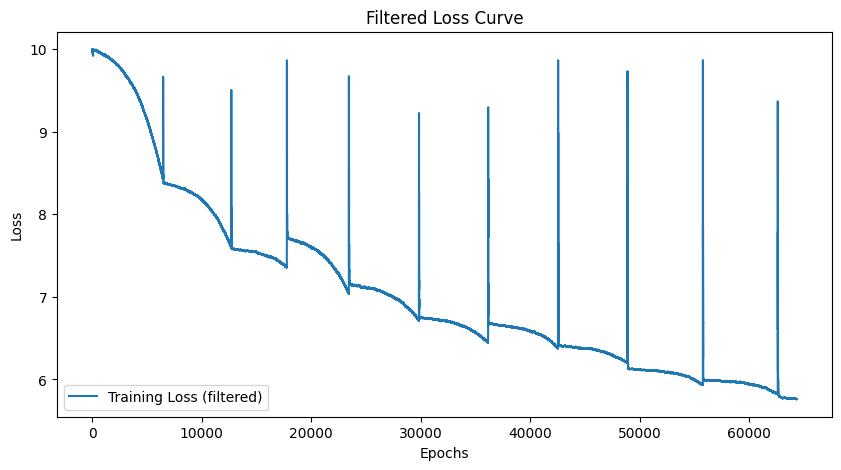

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(filtered_losses, label='Training Loss (filtered)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Filtered Loss Curve')
plt.legend()
plt.show()
